# Import Libraries

In [19]:
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Load Dataset

In [20]:
basePath = "C:\\Users\\taylan\\Desktop\\data_mining\\data"

files = glob.glob(basePath + "/*")
isFirst = True
dataFrame = ""

for i in files:
    for j in glob.glob(i+"/*"):
        if len(j.split(".")) == 1 :
            for k in glob.glob(j + "/*"):
                if isFirst == True:
                    dataFrame = pd.read_json(k)
                    isFirst = False
                else:
                    dataFrame = pd.concat([dataFrame, pd.read_json(k)], ignore_index=True)
                
        else:
            dataFrame = pd.concat([dataFrame, pd.read_json(j)], ignore_index=True)

# Preprocessing

In [21]:
dataFrame = dataFrame.drop(["tags", "pool_id", "sandbox_id", "timestamp_str", "ip"], axis=1)

In [22]:
dataFrame = dataFrame[dataFrame["cmd"].isnull() == False]
dataFrame = dataFrame[dataFrame["cmd_type"].isnull() == False]

In [23]:
import re

def remove_non_english_words(text):
    english_word_pattern = re.compile(r'\b[a-zA-Z]+\b')

    english_words = english_word_pattern.findall(text)
    
    result_text = ' '.join(english_words)
    
    return result_text

In [24]:
commandList = dataFrame["cmd"]
commandListParametersRemoved = [] # initially empty list
for item in commandList:
    item = (item.split(" ")[0]).split("_")[0]
    item = remove_non_english_words(item)
    commandListParametersRemoved.append(item)
dataFrame["cmd"] = commandListParametersRemoved

dataFrame["username"] = dataFrame["username"].fillna("unknown")
dataFrame["wd"] = dataFrame["wd"].fillna("unknown")



wdListRemoved = []
for item in dataFrame["wd"]:
    if "/" in item:
        item = item.split("/")[1]
    wdListRemoved.append(item)

dataFrame["wd"] = wdListRemoved

dataFrame


,cmd_type,hostname,cmd,username,wd
0,bash-command,attacker,nmap,root,root
1,bash-command,attacker,nmap,root,root
2,bash-command,attacker,service,root,root
3,bash-command,attacker,msfdb,root,root
4,bash-command,attacker,msfconsole,root,root
...,...,...,...,...,...
21103,bash-command,attacker,msfconsole,root,root
21104,msf-command,attacker,use,unknown,unknown
21105,msf-command,attacker,exploit,unknown,unknown
21106,msf-command,attacker,exit,unknown,unknown


In [25]:
dataFrame = dataFrame[dataFrame["cmd"].str.strip() != '']
dataFrame = dataFrame[dataFrame["username"].str.strip() != '']
dataFrame = dataFrame[dataFrame["wd"].str.strip() != '']

##

In [26]:
newDataFrame = pd.DataFrame()
newDataFrame["cmd"] = pd.factorize(dataFrame["cmd"])[0] + 1
newDataFrame["username"] = pd.factorize(dataFrame["username"])[0] + 1
newDataFrame["hostname"] = pd.factorize(dataFrame["hostname"])[0] + 1
newDataFrame["wd"] = pd.factorize(dataFrame["wd"])[0] + 1
newDataFrame["cmd_type"] = pd.factorize(dataFrame["cmd_type"])[0] + 1
newDataFrame


,cmd,username,hostname,wd,cmd_type
0,1,1,1,1,1
1,1,1,1,1,1
2,2,1,1,1,1
3,3,1,1,1,1
4,4,1,1,1,1
...,...,...,...,...,...
19649,4,1,1,1,1
19650,8,2,1,2,2
19651,11,2,1,2,2
19652,14,2,1,2,2


In [27]:
x = newDataFrame.drop(["cmd_type"], axis=1).values
y = newDataFrame["cmd_type"].values

# Train, Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)


In [29]:
X_train, X_test

(array([[21,  2,  1,  2],
        [61,  2,  1,  2],
        [63,  1,  4,  3],
        ...,
        [92,  1,  1,  1],
        [10,  2,  1,  2],
        [42,  7,  1,  3]], dtype=int64),
 array([[  6,   2,   1,   2],
        [  4,   1,   1,   1],
        [  8,   2,   1,   2],
        ...,
        [  8,   2,   1,   2],
        [270,   7,   1,   3],
        [ 15,   1,   4,   6]], dtype=int64))

In [30]:
y_train, y_test

(array([2, 2, 1, ..., 1, 2, 1], dtype=int64),
 array([2, 1, 2, ..., 2, 1, 1], dtype=int64))

# Train Model

In [31]:
randomForest = RandomForestClassifier()
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
svc = SVC()

modelList = [randomForest, knn, dtc, svc]
parameters = [{"n_estimators": range(1,30)}, 
              {"n_neighbors": range(1,30)}, 
              {"criterion":['gini', 'entropy', 'log_loss']}, 
              {"C": [1.0, 1.1, 1.2,1.3, 1.4,1.5]}
              ]

for i in range(len(modelList)):
    grid = GridSearchCV(estimator=modelList[i], param_grid=parameters[i], cv=5)
    grid.fit(X_train, y_train)
    print("estimator", grid.best_estimator_)
    print("score", grid.best_score_*100)
    y_predict = grid.predict(X_test)
    mse = mean_squared_error(y_pred= y_predict, y_true=y_test)
    print("mse", mse)


    

estimator RandomForestClassifier(n_estimators=1)
score 100.0
mse 0.0
estimator KNeighborsClassifier(n_neighbors=1)
score 99.56750912625603
mse 0.0035614347494276268
estimator DecisionTreeClassifier(criterion='entropy')
score 100.0
mse 0.0
estimator SVC(C=1.2)
score 84.65906292145901
mse 0.1545408293055202


# Visualize Results

In [32]:
confusionMatrix = confusion_matrix(y_true=y_test, y_pred=y_predict)
print(confusionMatrix)

[[4899 1004]
 [ 211 1748]]


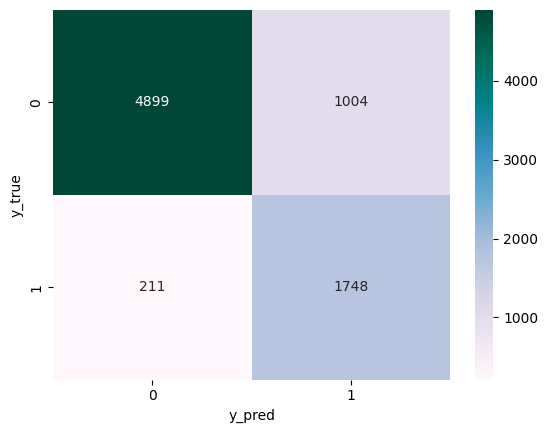

In [33]:
import seaborn
seaborn.heatmap(confusionMatrix, annot=True, fmt="d", cmap="PuBuGn")
import matplotlib.pyplot as plt 
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [34]:
report = classification_report(y_pred = y_predict, y_true=y_test)
print(report)


              precision    recall  f1-score   support

           1       0.96      0.83      0.89      5903
           2       0.64      0.89      0.74      1959

    accuracy                           0.85      7862
   macro avg       0.80      0.86      0.82      7862
weighted avg       0.88      0.85      0.85      7862

